# Audio Classification Using Deep Learning

## 1. Data Exploration and Visualisation

### Introduction

In this series of notebooks, we will describe step-by-step procedure for implementing audio classification using deep learning. This series will be breakdown into the following parts:

- Data Exploration and Visualisation
- Data Splitting and Feature Extraction
- Deep Learning Model Training and Evaluation
- Deep Learning Model Optimisation
- Discussion and Summmary

The packages used in this project are as follows:
- Python (v3.7)
- Scipy (v1.3.1)
- Librosa (v0.6.3)
- Scikit-Learn (v0.21.3)
- TensorFlow (v2.1.0)
- Optuna (v1.2.0)
- Pandas (v0.25.1)
- Matplotlib (v3.1.1)
- Seaborn (v0.9.0)

### Data exploration

We will use an excerpt from the [Google Speech Commands Dataset](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data) originally containing 65,000 sound clips (wav format) of 30 different words with duration approximately 1 second. In this project, we only use 23,682 clips comprising 10 different words.

It is important to understand the dataset before going deeper into the subsequent process. Here, we will explore the information about the dataset, such as sampling rate, duration, class (i.e. label) name, class distribution, waveform shape, etc. We use wavfile function from scipy package to read the audio file.

In [29]:
import os
import glob
from scipy.io import wavfile
import numpy as np
dir_name = 'data' # directory name containing the dataset
# list of class (i.e. label) names
label_names = [label for label in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name,label))]
# sort the label names alphabetically
label_names.sort()
# count number of files within each label directory
label_length = [] # number of files coressponding to each label
label_plots = [] # representative file to be plotted
audio_length = [] # list of all audio length

for label in label_names:
    file_names = os.path.join(dir_name,label,"*.wav")
    file_lists = glob.glob(file_names)
    label_length.append(len(file_lists))
    print("# audio with label '{}' \t: {}".format(label,len(file_lists)))
    label_plots.append(file_lists[0])
    for file in file_lists:
        sr, audio = wavfile.read(file)
        audio_length.append(len(audio))
num_files = sum(label_length) 

print("Sampling rate \t: {} Hz".format(sr)) 
print("# audio channel \t: {}".format(audio.ndim)) 
print("# total audio files \t: {}".format(num_files))       
audio_length = np.asarray(audio_length)
print("maximum audio length \t: {}".format(np.max(audio_length)))
print("minimum audio length \t: {}".format(np.min(audio_length)))
print("# audio > 1 second \t: {}".format(len(np.where(audio_length > sr)[0])))
print("# audio = 1 second \t: {}".format(len(np.where(audio_length == sr)[0])))
print("# audio < 1 second \t: {}".format(len(np.where(audio_length < sr)[0])))

# audio with label 'down' 	: 2359
# audio with label 'go' 	: 2372
# audio with label 'left' 	: 2353
# audio with label 'no' 	: 2375
# audio with label 'off' 	: 2357
# audio with label 'on' 	: 2367
# audio with label 'right' 	: 2367
# audio with label 'stop' 	: 2380
# audio with label 'up' 	: 2375
# audio with label 'yes' 	: 2377
Sampling rate 	: 16000 Hz
# audio channel 	: 1
# total audio files 	: 23682
maximum audio length 	: 16000
minimum audio length 	: 6688
# audio > 1 second 	: 0
# audio = 1 second 	: 21312
# audio < 1 second 	: 2370


From the above result, we know that the majority of audio clips have 1 second duration and none of them have more than 1 second duration. To deal with the difference in audio duration (i.e. number of samples), we will implement zero padding to equalise the number of samples. The proportion of class is almost equal, each having ~10% as shown in the pie chart below. This means we do not have to deal with the imbalance dataset issue.

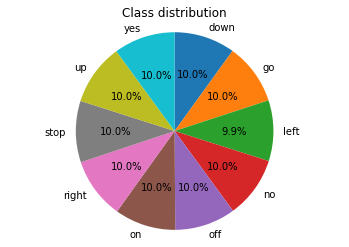

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.pie(label_length, labels=label_names, autopct='%1.1f%%',
        shadow=False, startangle=90, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()

### Data Visualisation

Now, let's take a look at an example waveform of audio clip from each class (the plot shown below). To plot the audio and do audio processing in the next notebooks, we use Librosa: a python package commonly used for music and audio analysis. Before plotting and further processing, we pad the audio input that has < 1 second duration with zeros using pad_input custom function. Inside this function, we change the the data type from integer to float32. 

sampling: 16000, audio length: 16000, paded audio length: 16000
sampling: 16000, audio length: 11146, paded audio length: 16000
sampling: 16000, audio length: 16000, paded audio length: 16000
sampling: 16000, audio length: 16000, paded audio length: 16000
sampling: 16000, audio length: 16000, paded audio length: 16000
sampling: 16000, audio length: 11889, paded audio length: 16000
sampling: 16000, audio length: 14336, paded audio length: 16000
sampling: 16000, audio length: 13375, paded audio length: 16000
sampling: 16000, audio length: 14861, paded audio length: 16000
sampling: 16000, audio length: 16000, paded audio length: 16000


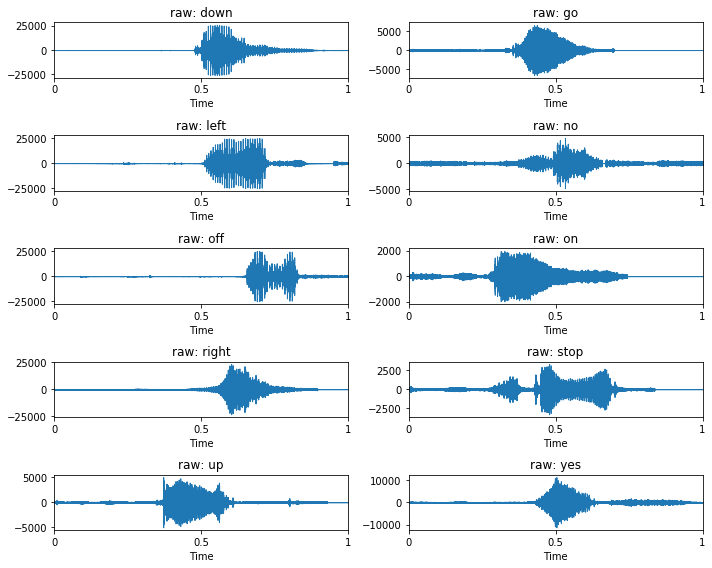

In [26]:
import librosa
import librosa.display # for plotting
from preprocessing import pad_input
audio_plots = []
for i,file in enumerate(label_plots):
    sr, audio = wavfile.read(file)
    audio_plots.append(pad_input(audio))
    print("sampling: {}, audio length: {}, paded audio length: {}".format(sr,len(audio),len(audio_plots[i])))

title_plot = 'raw'
nrow = 5
ncol = 2
fig = plt.figure(figsize=(10,8))
for r in range(len(label_names)):
    plt.subplot(nrow,ncol,r+1)
    librosa.display.waveplot(audio_plots[r], sr=sr)
    plt.title("{}: {}".format(title_plot,label_names[r]))
    plt.xlim(0,1)
    plt.locator_params(axis='x', nbins=3)
plt.tight_layout()

In audio-based applications, the analysis is commonly performed in the frequency domain since this often results in easier and better representation of information contained in the audio. In the next section, we will extract this informative representation (i.e. feature) in the frequency domain using [Librosa](https://librosa.github.io/librosa/) package.